<a href="https://colab.research.google.com/github/SaiRajesh228/DeepLearningAssignment1/blob/main/q11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
from keras.datasets import fashion_mnist
import wandb

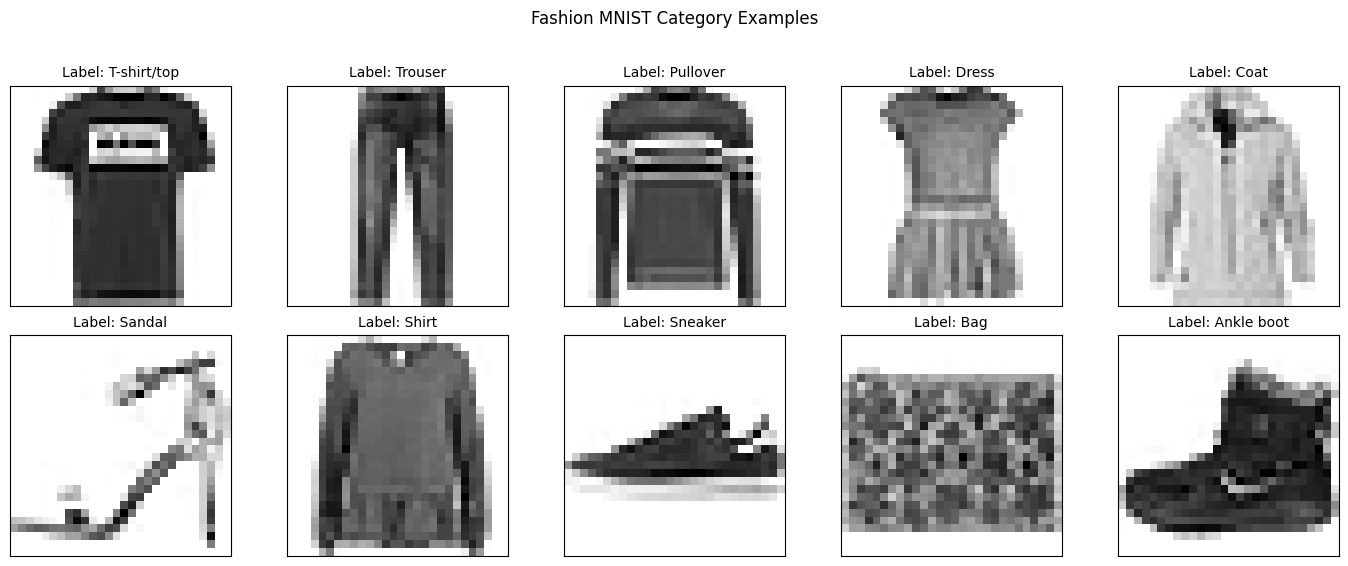

In [39]:


# Load Fashion MNIST dataset
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# Define fashion item categories
garment_types = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Configure visualization layout
row_count, col_count = 2, 5
figure, axis_grid = plt.subplots(row_count, col_count, figsize=(14, 5.5), squeeze=False)
axis_grid = axis_grid.ravel()  # Flatten grid for easy iteration

# Visualize sample images from each category
for category_idx, garment in enumerate(garment_types):
    # Locate first instance of current category
    sample_index = np.argmax(train_labels == category_idx)

    # Configure subplot appearance
    current_axis = axis_grid[category_idx]
    current_axis.imshow(train_images[sample_index], cmap='binary')
    current_axis.set_title(f"Label: {garment}", fontsize=10)
    current_axis.set_xticks([])
    current_axis.set_yticks([])

# Finalize layout and display
plt.suptitle('Fashion MNIST Category Examples', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

In [42]:
def categorical_representation(input_labels, category_count=None):

    if category_count is None:
        category_count = np.max(input_labels) + 1

    if np.any(input_labels >= category_count):
        raise ValueError("Input contains labels exceeding category count")

    # Create identity matrix for category mapping
    identity_matrix = np.identity(category_count, dtype=np.float32)
    return identity_matrix[input_labels]

In [43]:
def initialize_network_params(layer_dims, init_scheme):


    if not isinstance(layer_dims, (list, tuple)) or len(layer_dims) < 2:
        raise ValueError("Invalid layer dimensions specification")

    if init_scheme not in {'random', 'xavier'}:
        raise ValueError("Unsupported initialization method")

    weight_list = []
    bias_list = []
    rng = np.random.default_rng()

    for prev_dim, curr_dim in zip(layer_dims[:-1], layer_dims[1:]):
        # Weight matrix initialization
        if init_scheme == 'random':
            weights = rng.normal(scale=0.1, size=(curr_dim, prev_dim))
        else:  # Xavier initialization
            scale = np.sqrt(2.0 / (prev_dim + curr_dim))
            weights = rng.normal(scale=scale, size=(curr_dim, prev_dim))

        # Bias vector initialization
        biases = np.zeros((curr_dim, 1))

        weight_list.append(weights)
        bias_list.append(biases)

    return weight_list, bias_list

In [44]:
import numpy as np

class NeuralActivations:


    @staticmethod
    def linear_rectifier(inputs):

        return np.clip(inputs, 0, None)

    @staticmethod
    def logistic(inputs):

        inputs = np.clip(inputs, -50, 50)  # Prevent overflow
        return 1 / (1 + np.exp(-inputs))

    @staticmethod
    def hyperbolic_tangent(inputs):

        return np.tanh(np.clip(inputs, -10, 10))

    @staticmethod
    def stable_softmax(inputs):

        shifted = inputs - np.max(inputs, axis=0, keepdims=True)
        exponents = np.exp(shifted)
        return exponents / np.sum(exponents, axis=0, keepdims=True)

    @classmethod
    def get_activation(cls, inputs, func_type):

        activations = {
            'rectifier': cls.linear_rectifier,
            'logistic': cls.logistic,
            'tanh': cls.hyperbolic_tangent,
            'softmax': cls.stable_softmax
        }
        if func_type not in activations:
            raise ValueError(f"Unsupported activation: {func_type}")
        return activations[func_type](inputs)

class ActivationGradients:


    @staticmethod
    def logistic_grad(activations):

        return activations * (1 - activations)

    @staticmethod
    def tanh_grad(activations):

        return 1 - np.square(activations)

    @staticmethod
    def rectifier_grad(activations):

        return (activations > 0).astype(np.float32)

    @classmethod
    def get_gradient(cls, activations, func_type):

        gradients = {
            'rectifier': cls.rectifier_grad,
            'logistic': cls.logistic_grad,
            'tanh': cls.tanh_grad
        }
        if func_type not in gradients:
            raise ValueError(f"Unsupported gradient type: {func_type}")
        return gradients[func_type](activations)

In [46]:
def compute_layer_transform(input_data, weight_matrix, bias_term, activation):

    # Compute linear combination of inputs
    linear_combination = weight_matrix @ input_data + bias_term

    # Apply nonlinear activation
    activated_output = apply_nonlinearity(linear_combination, activation)

    return linear_combination, activated_output

def network_forward_pass(input_sample, weight_params, bias_params, activations):

    # Validate parameter dimensions
    if len(weight_params) != len(activations) or len(weight_params) != len(bias_params):
        raise ValueError("Parameter/activation list length mismatch")

    # Initialize storage for network signals
    signal_history = [input_sample]
    linear_outputs = []

    # Process through network layers
    for layer_idx, (weights, biases) in enumerate(zip(weight_params, bias_params)):
        # Verify dimensional compatibility
        if weights.shape[1] != signal_history[-1].shape[0]:
            raise ValueError(f"Layer {layer_idx} input dimension mismatch")

        # Compute layer transformations
        linear, activated = compute_layer_transform(
            signal_history[-1],
            weights,
            biases,
            activations[layer_idx]
        )

        # Store network signals
        linear_outputs.append(linear)
        signal_history.append(activated)

    return linear_outputs, signal_history

In [ ]:
def compute_parameter_gradients(weight_params, bias_params, true_labels,
                              linear_outputs, activations, activation_funcs,
                              batch_size):

    # Validate input dimensions
    if len(weight_params) != len(activation_funcs):
        raise ValueError("Parameter/activation count mismatch")

    weight_grads = []
    bias_grads = []
    delta = None  # Initialize error signal

    # Reverse process through layers
    for layer_idx in reversed(range(len(weight_params))):
        current_weights = weight_params[layer_idx]

        # Output layer gradient calculation
        if layer_idx == len(weight_params) - 1:
            delta = (activations[-1] - true_labels) / batch_size
        else:
            # Hidden layer gradient calculation
            derivative = compute_activation_gradient(
                linear_outputs[layer_idx],
                activation_funcs[layer_idx]
            )
            delta = (current_weights.T @ delta) * derivative

        # Compute parameter gradients
        input_activation = activations[layer_idx]
        weight_gradient = delta @ input_activation.T
        bias_gradient = np.sum(delta, axis=1, keepdims=True)

        weight_grads.append(weight_gradient)
        bias_grads.append(bias_gradient)

    # Reverse to match layer order
    return weight_grads[::-1], bias_grads[::-1]

def update_network_parameters(weight_params, bias_params,
                            weight_grads, bias_grads,
                            learning_rate):

    # Validate gradient/parameter alignment
    if len(weight_params) != len(weight_grads):
        raise ValueError("Weight parameters/gradients count mismatch")

    updated_weights = []
    updated_biases = []

    for weights, biases, w_grad, b_grad in zip(weight_params, bias_params,
                                             weight_grads, bias_grads):
        # Parameter update step
        new_weights = weights - learning_rate * w_grad
        new_biases = biases - learning_rate * b_grad

        updated_weights.append(new_weights)
        updated_biases.append(new_biases)

    return updated_weights, updated_biases